## Clustering


### User Clustering
Can we find a set of features in which our users form clusters, or are we going to be looking at a fairly random distribution in the feature space?  I would like to know this as it will effect my strategy in the recommender system.  If users are evenly spaced out, I'll use K Nearest Neighbours.  But if they cluster up nicely, I'll use K-Means.

Since the recommender system will need to build a seperate model for each condition, we will cluster the users on a per-condition basis, as usual starting with Depression since it is best represented at this time.

For this analysis we will start with the effectiveness data, which has already taken on some preprocessing.  It is currently in the format of one row per user/condition/treatment combination.  Since we are trying to describe our users in the case, I will extract the users affected by the condition we are currently examining, and then pivot them to one row per user.

In [38]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("effectiveness_082516.csv")
#print df.pivot_table(index=['user_id','condition'],columns='treatment',values='effectiveness')
depressed_df = df[df['condition'] == 'Depression'].pivot_table(index='user_id',columns='treatment',values='effectiveness').reset_index()
depressed_df = depressed_df.fillna(0)
depressed_df.drop('user_id', axis=1, inplace=True)
print len(depressed_df.columns)

2507


Given the high number of features, I'm going to try manifold learning.  I can't visualize 2500 dimensions.  It's a personal failing that I'm working on.

http://scikit-learn.org/stable/modules/manifold.html

First, lets see how few dimensions we can get down to with PCA:

([<matplotlib.axis.XTick at 0x7fc7a3aefdd0>,
 <a list of 5 Text xticklabel objects>)

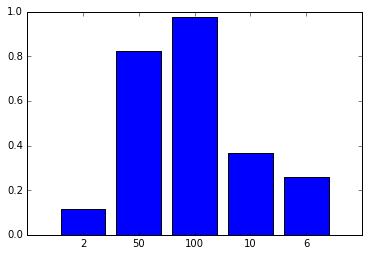

In [14]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

variances = {}
for components in [2,6,10,50,100]:
    pca = PCA(n_components=components)
    pca.fit(depressed_df)
    variances[components] = np.sum(pca.explained_variance_ratio_)
fit_data = pca.transform(depressed_df)
plt.bar(range(len(variances)), variances.values(), align='center')
plt.xticks(range(len(variances)), variances.keys())

Not low enough to visualize.  But [this paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) says that we should be able to get much lower to t-sne.  So lets try that.


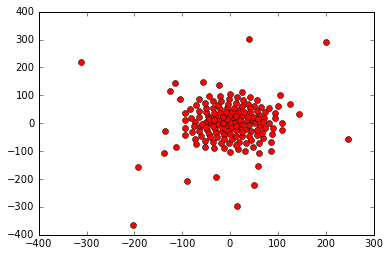

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE()
transformed = tsne.fit_transform(depressed_df) 
plt.plot(transformed[:,0], transformed[:,1], 'ro')

Not exactly briming with confidence about being able to cluster that.  It's basically a blob with a few outliers.  But before we proceed, instead of trying to visualize, I'm going to try K-means on the PCA data and check the [rand score.](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

The reason that I feel the need to do this check is that the problem with t-SNE is, it doesn't have an effective performance metric like PCA's explained variance ratio.  So I don't know just how well the above graph is representing the data.


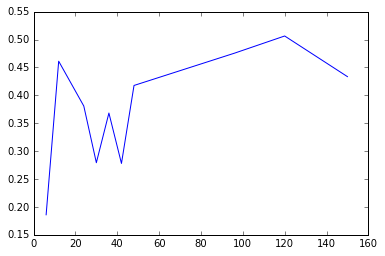

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def plot_cluster_nums(n_cluster_range):
    scores = []
    for num_clusters in n_cluster_range:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(depressed_df)
        pred = kmeans.predict(depressed_df)
        scores.append(silhouette_score(depressed_df, pred))
        #print "Silhouette Score at " +str(num_clusters) + " = " + str(silhouette_score(depressed_df, pred))
    plt.plot(n_cluster_range,scores)
plot_cluster_nums([6, 12, 24,30, 36, 42, 48, 96, 120, 150])

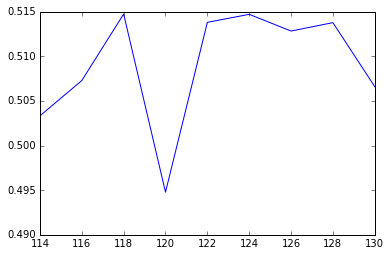

In [36]:
#Now just going to fine tune to find that sweet spot
plot_cluster_nums([114,116,118,120,122,124,126,128,130])

A silouette score of 0.515 is better than I was expecting.  As a result of this, I would say that the user-based recommender system defintely has K-means as an option.  It may be necessary to attempt both K-means and Nearest Neighbour to see which works better.


### Condition Segmentation

One of the most hopeful uses of the flaredown data is to use it to identify sub-classifications of some of the conditions.

Many of the conditions being reported have treatments that work for some people but not others.  Many conditions also vary greatly in terms of the symptoms that the afflicted will experience.  We will attempt to find clusters within some of the conditions reported on Flaredown based off of symptoms and treatment effectiveness.  The hope is to find sub-classes of conditions that can be used for a more specific diagnosis.

This is very similar to what we did to validate the recommender system.  We will cluster on users per condition, except this time we will include symptoms.  We will run through all of our conditions and check for very high silouette scores, indicating that some users are experiencing a single condition much differently than other users.

NOTE: may want to hold off on this one tell we get more samples, since we know going in it isn't going to produce significant results.

### Condition Clustering

Our exploration has shown that the Flaredown users are reporting heaps of conditions simultaneously.  The conditions that occur together may be interesting.  PCA may provide an informative way of looking at this.